Most classification algorithms form a model (some sort of functional mapping) that maps input data to output. But decision trees adopt a different strategy. Decision trees divide the input space into regions and do classification based on majority vote in each region. Let's consider an example that has a single predictor and the target values are either 0, 1, or 2. Most of the times there is no clear separation of labels in terms of predictor values. In that case, a predictor value is chosen that maximizes the information gain. If the predictor varies between (0,100), first separation can be made anywhere between 1 to 99. So information gain is computed for all possible separation points starting form 1 to 99. The first cut is made at a value for which information gain is maximum. 

Calculation of information gain is not direct. Rather, information gain depends on impurity function of each group that appear after separation. There are several choices for impurity function. We will not go into the details of it here. We will save that for a later time. For the time being interested readers can refer to [this excellent short paper](https://www.nature.com/articles/nmeth.4370) or this [excellent book](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Sixth%20Printing.pdf).


## Description of data

[Detailed discussion of how to prepare the data and its source can be found in this post.](https://github.com/biswajitsahoo1111/cbm_codes_open/blob/master/notebooks/SVM_wavelet_energy_multiclass_cwru_python.ipynb) Here we will only mention about different classes of the data. There are 10 classes and data for each class are taken at a load of 1hp. The classes are:

* C1  : Ball defect (0.007 inch)
* C2  : Ball defect (0.014 inch)
* C3  : Ball defect (0.021 inch)
* C4  : Inner race fault (0.007 inch)
* C5  : Inner race fault (0.014 inch)
* C6  : Inner race fault (0.021 inch)
* C7  : Normal
* C8  : Outer race fault (0.007 inch, data collected from 6 O'clock position)
* C9  : Outer race fault (0.014 inch, 6 O'clock)
* C10 : Outer race fault (0.021 inch, 6 O'clock)

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix,accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

### How to get data?

Readers can download the `.csv` file used in this notebook from [here](https://github.com/biswajitsahoo1111/cbm_codes_open/blob/master/notebooks/data/feature_wav_energy8_48k_2048_load_1.csv). Another convenient way is to [download the whole repository](https://codeload.github.com/biswajitsahoo1111/cbm_codes_open/legacy.zip/master) and run the downloaded notebooks.

In [2]:
data_wav_energy = pd.read_csv("./data/feature_wav_energy8_48k_2048_load_1.csv")

In [3]:
train_data, test_data = train_test_split(data_wav_energy, test_size = 750, stratify = data_wav_energy['fault'],
                                         random_state = 1288)

In [4]:
tree_clf = DecisionTreeClassifier(random_state = 532)

In [5]:
tree_clf.fit(train_data.iloc[:,:-1], train_data['fault'])

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=532, splitter='best')

In [6]:
train_predictions = tree_clf.predict(train_data.iloc[:,:-1])
test_predictions = tree_clf.predict(test_data.iloc[:,:-1])

In [7]:
overall_train_accuracy = accuracy_score(train_data['fault'], train_predictions)
print("Overall train accuracy: ", overall_train_accuracy)

Overall train accuracy:  1.0


In [8]:
train_confu_matrix = confusion_matrix(train_data['fault'], train_predictions)
test_confu_matrix = confusion_matrix(test_data['fault'], test_predictions)

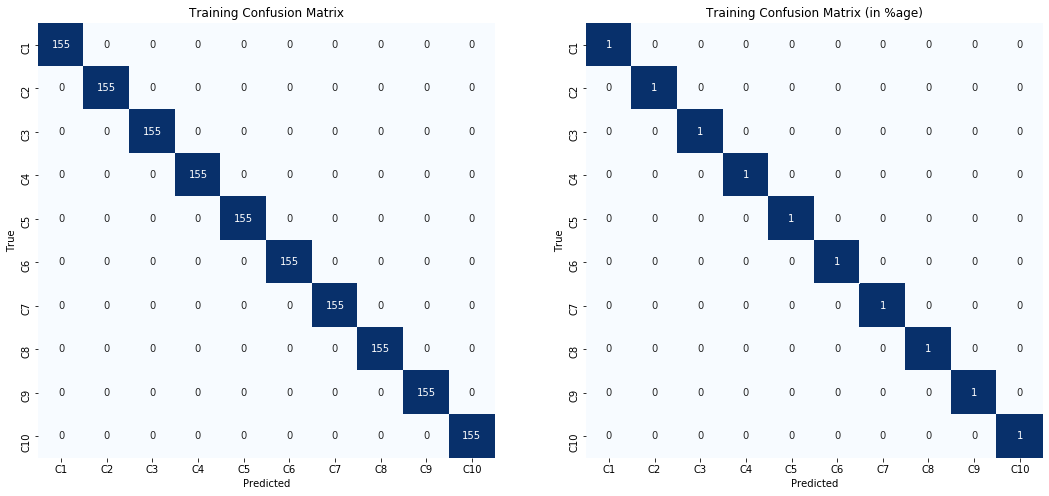

In [9]:
fault_type = ['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10']
plt.figure(1,figsize=(18,8))
plt.subplot(121)
sns.heatmap(train_confu_matrix, annot= True,fmt = "d",
xticklabels=fault_type, yticklabels=fault_type, cmap = "Blues", cbar = False)
plt.title('Training Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.subplot(122)
sns.heatmap(train_confu_matrix/155, annot= True,
xticklabels=fault_type, yticklabels=fault_type, cmap = "Blues", cbar = False)
plt.title('Training Confusion Matrix (in %age)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()    

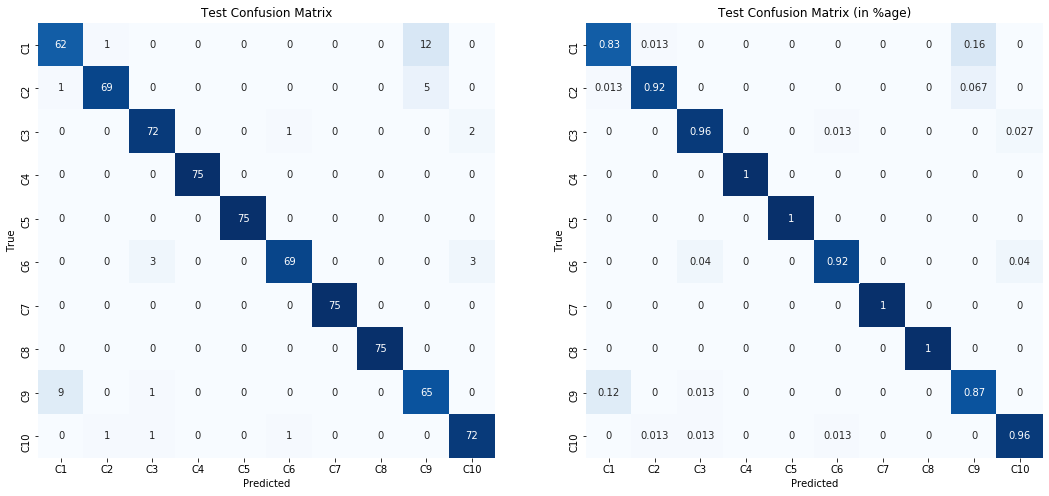

In [10]:
plt.figure(2,figsize=(18,8))
plt.subplot(121)
sns.heatmap(test_confu_matrix, annot = True,
xticklabels=fault_type, yticklabels=fault_type, cmap = "Blues", cbar = False)
plt.title('Test Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.subplot(122)
sns.heatmap(test_confu_matrix/75, annot = True,
xticklabels=fault_type, yticklabels=fault_type, cmap = "Blues", cbar = False)
plt.title('Test Confusion Matrix (in %age)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [11]:
overall_test_accuracy = accuracy_score(test_data['fault'], test_predictions)
print("Overall test accuracy: ", overall_test_accuracy)

Overall test accuracy:  0.9453333333333334


## Whether to prune or not?
In practice, fully grown trees usually overfit. We can easily achieve 100% accuracy on training data by growing arbitrarily deep trees. But these trees perform poorly on test data. Therefore, trees are pruned at a suitable depth to enhance their generalization capacity. Next obvious question is, where to prune? We will use cost complexity pruing. In this method, a hyper parameter is selected that acts as a regularizer on the depth of tree. We will increase the hyperparameter from 0 to some value and check its effect on test accuracy. This will guide our pruing strategy.

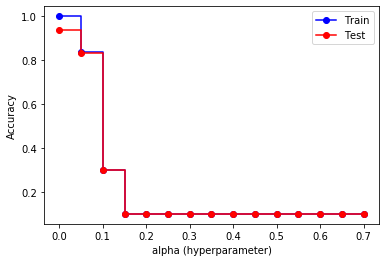

In [12]:
ccp_alphas = np.linspace(0, 0.7, num = 15)
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(train_data.iloc[:,:-1], train_data['fault'])
    clfs.append(clf)

train_scores = [clf.score(train_data.iloc[:,:-1], train_data['fault']) for clf in clfs]
test_scores = [clf.score(test_data.iloc[:,:-1], test_data['fault']) for clf in clfs]
plt.figure()
plt.plot(ccp_alphas, train_scores,'-o', color = "blue", label = "Train", drawstyle = "steps-post")
plt.plot(ccp_alphas, test_scores, '-o', color = "red", label = "Test", drawstyle = "steps-post")
plt.xlabel("alpha (hyperparameter)")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

As we can see increasing the regularizer has no effect on test accuracy. Therefore, we will go with fully grown tree. 

[To see results of other techniques applied to public condition monitoring datasets, visit this page](https://biswajitsahoo1111.github.io/cbm_codes_open/).